# Valuation of American Options
# with Least-Squares Monte Carlo
### Primal and Dual Algorithm
### Case 1: American Put Option (APO)
### Case 2: Short Condor Spread (SCS)
code from [07_amo/LSM_primal_dual_valuation.py](https://github.com/yhilpisch/dawp/blob/master/dawp/book/07_amo/LSM_primal_dual_table.py)

(c) Dr. Yves J. Hilpisch
Derivatives Analytics with Python


In [1]:
import math
import numpy as np
import pandas as pd
from time import time
from datetime import datetime
import itertools as it
import warnings
warnings.simplefilter('ignore')

t0 = time()
np.random.seed(150000) # seed for Python RNG

In [3]:
## Simulation Parameters
runs = 25
write = True
#otype = [1, 2]  # option type
otype = [1]  # option type
#M = [10, 25, 50]  # time steps
M = [10]  # time steps
I1 = np.array([4]) * 4096  # replications for regression
I2 = np.array([1]) * 1024  # replications for valuation
J = [50]  # replications for nested MCS
reg = [18]  # no of basis functions
AP = [False]  # antithetic paths
MM = [True]  # moment matching of RN
ITM = [False] # ITM paths for regression

results = pd.DataFrame()

In [4]:
def generate_random_numbers(I):
    ''' Function to generate I pseudo-random numbers. '''
    if AP:
            ran = np.random.standard_normal(I / 2)
            ran = np.concatenate((ran, -ran))
    else:
            ran = np.random.standard_normal(I)
    if MM:
        ran = ran - np.mean(ran)
        ran = ran / np.std(ran)
    return ran

In [5]:
def generate_paths(I):
    ''' Function to generate I stock price paths. '''
    S = np.zeros((M + 1, I), dtype=np.float)  # stock matrix
    S[0] = S0  # initial values
    for t in range(1, M + 1, 1):  # stock price paths
        ran = generate_random_numbers(I)
        S[t] = S[t - 1] * np.exp((r - sigma ** 2 / 2) * dt
                                + sigma * ran * math.sqrt(dt))
    return S


In [6]:
def inner_values(S):
    ''' Innver value functions for American put and Short Condor Spread. '''
    if otype == 1:
        return np.maximum(40. - S, 0)
    else:
        return np.minimum(40., np.maximum(90. - S, 0)
                             + np.maximum(S - 110., 0))



In [7]:
def nested_monte_carlo(St, J):
    ''' Function for nested Monte Carlo simulation.
    Parameters
    ==========
    St : float 
        start value for S
    J : int
        number of paths to simulate
    Returns
    =======
    paths : array
        simulated nested paths
    '''
    ran = generate_random_numbers(J)
    paths = St * np.exp((r - sigma ** 2 / 2) * dt
                       + sigma * ran * math.sqrt(dt))
    return paths


In [12]:
a = np.array([[1, 2,4, 6]])
c = np.compress([False, True,False,True], a)

a
c

array([2, 6])

In [8]:
#
# Valuation
#
para = it.product(otype, M, I1, I2, J, reg, AP, MM, ITM)
count = 0
for pa in para:
    otype, M, I1, I2, J, reg, AP, MM, ITM = pa
    ## General Parameters and Option Values
    if otype == 1:
        ## Parameters -- American Put Option
        S0 = 36.  # initial stock level
        T = 1.0  # time-to-maturity
        r = 0.06  # short rate
        sigma = 0.2  # volatility
        V0_true = 4.48637  # American Put Option (500 steps bin. model) not used in calculation
    else:
        ## Parameters -- Short Condor Spread
        S0 = 100.  # initial stock level
        T = 1.0  # time-to-maturity
        r = 0.05  # short rate
        sigma = 0.5  # volatility
        V0_true = 26.97705  # Short Condor Spread (500 steps bin. model)
    dt = T / M  # length of time interval
    df = math.exp(-r * dt)  # discount factor per time interval
    for j in range(runs): # number runs
        count += 1
        # regression estimation
        S = generate_paths(I1)  # generate stock price paths
        h = inner_values(S)  # inner values
        V = inner_values(S)  # value matrix
        rg = np.zeros((M + 1, reg + 1), dtype=np.float) 
            # regression parameter matrix

        ### if the value ist greater than zero    
        itm = np.greater(h, 0)  # ITM paths
        ## backward process start
        for t in range(M - 1, 0, -1): #Time backward
            if ITM:
                S_itm = np.compress(itm[t] == 1, S[t])
                V_itm = np.compress(itm[t] == 1, V[t + 1])
                if len(V_itm) == 0:
                    rg[t] = 0.0
                else:
                    rg[t] = np.polyfit(S_itm, V_itm * df, reg)
            else:
                #Regression part
                rg[t] = np.polyfit(S[t], V[t + 1] * df, reg)
                  # regression at time t
            C = np.polyval(rg[t], S[t])  # calculate continuation with regeression parameters
            V[t] = np.where(h[t] > C, h[t], V[t + 1] * df)
              # exercise decision compare Values with continuation

        ## Simulation
        Q = np.zeros((M + 1, I2), dtype=np.float)  # martingale matrix
        U = np.zeros((M + 1, I2), dtype=np.float)  # upper bound matrix
        S = generate_paths(I2)  # generate stock price paths
        h = inner_values(S)  # inner values
        V = inner_values(S)  # value matrix

        ## Primal Valuation
        for t in range(M - 1, 0, -1):
            C = np.polyval(rg[t], S[t])  # continuation values
            V[t] = np.where(h[t] > C, h[t], V[t + 1] * df)
              # exercise decision
        V0 = df * np.sum(V[1]) / I2  # LSM estimator

        ## Dual Valuation
        for t in range(1, M + 1):
            for i in range(I2):
                Vt = max(h[t, i], np.polyval(rg[t], S[t, i]))
                # estimated value V(t,i)
                St = nested_monte_carlo(S[t - 1, i], J)  # nested MCS
                Ct = np.polyval(rg[t], St)  # cv from nested MCS
                ht = inner_values(St)  # iv from nested MCS
                VtJ = np.sum(np.where(ht > Ct, ht, Ct)) / len(St)
                  # average of V(t,i,j)
                Q[t, i] = Q[t - 1, i] / df + (Vt - VtJ)  # "optimal" martingale
                U[t, i] = max(U[t - 1, i] / df, h[t, i] - Q[t, i])
                  # high estimator values
                if t == M:
                    U[t, i] = np.maximum(U[t - 1, i] / df,
                                         np.mean(ht) - Q[t, i])
        U0 = np.sum(U[M]) / I2 * df ** M  # DUAL estimator
        AV = (V0 + U0) / 2  # average of LSM and DUAL estimator

        # output
        print ("%4d | %4.1f | %48s " % (count, (time() - t0) / 60, pa), \
                "| %6.3f | %6.3f | %6.3f" % (V0, U0, AV))
        # results storage
        results = results.append(pd.DataFrame({'otype': otype, 'runs': runs,
            'M': M, 'I1': I1, 'I2': I2, 'J': J, 'reg': reg, 'AP': AP,
            'MM': MM, 'ITM': ITM, 'LSM': V0, 'LSM_se': (V0 - V0_true) ** 2,
            'DUAL': U0, 'DUAL_se': (U0 - V0_true) ** 2, 'AV': AV,
            'AV_se': (AV - V0_true) ** 2}, index=[0,]), ignore_index=True)

t1 = time()
print ("Total time in sec %s" % ((t1 - t0) / 60))

if write:
    h5 = pd.HDFStore('results_%s_%s.h5' % (datetime.now().date(),
                                        str(datetime.now().time())[:8]), 'w')
    h5['results'] = results
    h5.close()

   1 |  0.8 | (1, 10, 16384, 1024, 50, 18, False, True, False)  |  4.446 |  4.741 |  4.593
   2 |  0.8 | (1, 10, 16384, 1024, 50, 18, False, True, False)  |  4.390 |  4.821 |  4.606
   3 |  0.8 | (1, 10, 16384, 1024, 50, 18, False, True, False)  |  4.443 |  4.792 |  4.617
   4 |  0.9 | (1, 10, 16384, 1024, 50, 18, False, True, False)  |  4.516 |  5.175 |  4.846
   5 |  0.9 | (1, 10, 16384, 1024, 50, 18, False, True, False)  |  4.415 |  4.940 |  4.678
   6 |  0.9 | (1, 10, 16384, 1024, 50, 18, False, True, False)  |  4.414 |  4.787 |  4.600
   7 |  0.9 | (1, 10, 16384, 1024, 50, 18, False, True, False)  |  4.406 |  4.733 |  4.570
   8 |  1.0 | (1, 10, 16384, 1024, 50, 18, False, True, False)  |  4.379 |  6.259 |  5.319
   9 |  1.0 | (1, 10, 16384, 1024, 50, 18, False, True, False)  |  4.496 |  4.753 |  4.625
  10 |  1.0 | (1, 10, 16384, 1024, 50, 18, False, True, False)  |  4.433 |  4.756 |  4.594
  11 |  1.0 | (1, 10, 16384, 1024, 50, 18, False, True, False)  |  4.547 |  4.752 |  4.650

### Regression Part

df -> discountingfactor

rg[t] = np.polyfit(S[t], V[t + 1] * df, reg) Simannealing

Reg S(t) -> V(t+1)
 
 
 
Continutiation 
 
C = np.polyval(rg[t], S[t])  # continuation values



Excercsise Decisison

 V[t] = np.where(h[t] > C, h[t], V[t + 1] * df)
 
 
 h contains Values Stock - Stricke

In [31]:
len(S[8])

1024

In [32]:
C

array([ 2.71297193,  2.91503985,  3.23903644, ...,  4.62126469,
        7.83117158,  4.69378089])

In [34]:
h[10]

array([  0.        ,   0.        ,   5.44783944, ...,  11.78620236,
        15.25952949,   0.        ])

In [20]:
print(results)

        AP         AV      AV_se       DUAL     DUAL_se     I1    I2    ITM  \
0    False   4.600138   0.012943   4.741538    0.065111  16384  1024  False   
1    False   4.566411   0.006407   4.738758    0.063699  16384  1024  False   
2    False   4.607059   0.014566   4.770459    0.080706  16384  1024  False   
3    False   4.616919   0.017043   4.749970    0.069485  16384  1024  False   
4    False   4.571657   0.007274   4.731837    0.060254  16384  1024  False   
5    False   4.581369   0.009025   4.761975    0.075958  16384  1024  False   
6    False   4.573873   0.007657   4.739087    0.063866  16384  1024  False   
7    False   4.568460   0.006739   4.753701    0.071466  16384  1024  False   
8    False   4.629502   0.020487   4.752824    0.070998  16384  1024  False   
9    False   4.594989   0.011798   4.757475    0.073498  16384  1024  False   
10   False   4.646512   0.025646   4.748169    0.068539  16384  1024  False   
11   False   4.579281   0.008632   4.746633    0.067

In [21]:
# Store

h5 = pd.HDFStore('results_%s_%s.h5' % (datetime.now().date(),
                                        str(datetime.now().time())[:8]), 'w')
h5['results'] = results
h5.close()

In [22]:
ls

American Put Options.ipynb
LSM American Put Options APO SCS .ipynb
results_2017-02-07_11:50:46.h5
results_2017-02-07_11:57:18.h5


# Data Visualization

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 


data = pd.read_hdf("results_2017-02-07_11:57:18.h5")
data[:10]

,AP,AV,AV_se,DUAL,DUAL_se,I1,I2,ITM,J,LSM,LSM_se,M,MM,otype,reg,runs
0,False,4.600138,0.012943,4.741538,0.065111,16384,1024,False,50,4.458738,0.000764,10,True,1,9,25
1,False,4.566411,0.006407,4.738758,0.063699,16384,1024,False,50,4.394065,0.008520,10,True,1,9,25
2,False,4.607059,0.014566,4.770459,0.080706,16384,1024,False,50,4.443659,0.001824,10,True,1,9,25
3,False,4.616919,0.017043,4.749970,0.069485,16384,1024,False,50,4.483868,0.000006,10,True,1,9,25
4,False,4.571657,0.007274,4.731837,0.060254,16384,1024,False,50,4.411477,0.005609,10,True,1,9,25
5,False,4.581369,0.009025,4.761975,0.075958,16384,1024,False,50,4.400764,0.007328,10,True,1,9,25
6,False,4.573873,0.007657,4.739087,0.063866,16384,1024,False,50,4.408660,0.006039,10,True,1,9,25
7,False,4.568460,0.006739,4.753701,0.071466,16384,1024,False,50,4.383219,0.010640,10,True,1,9,25
8,False,4.629502,0.020487,4.752824,0.070998,16384,1024,False,50,4.506180,0.000392,10,True,1,9,25
9,False,4.594989,0.011798,4.757475,0.073498,16384,1024,False,50,4.432504,0.002902,10,True,1,9,25


In [28]:
out=data[['AV','DUAL','LSM']]
firstcalc=out[:75]
lastcalc=out[75:]

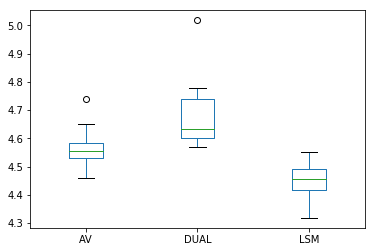

In [29]:
firstcalc.plot.box()

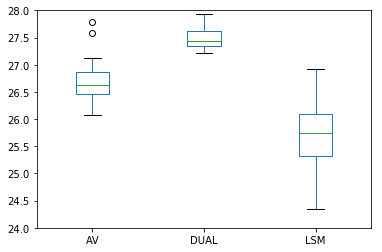

In [34]:
lastcalc.plot.box(ylim=[24,28])